In [0]:
# Education - Udacity "Intro to TensorFlow for Deep Learning"
# Module: Transfer Learning
# Ref: https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c01_tensorflow_hub_and_transfer_learning.ipynb

In [1]:
# Import packages.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import logging

# Using version 2.x of Tensorflow.
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Tensorflow.
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Set logging level.
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Print Tensorflow version.
print('TensorFlow Version:', tf.__version__)

TensorFlow 2.x selected.
TensorFlow Version: 2.1.0-rc1


In [0]:
# Download classifier.
# This model expects images of 224 x 224 with RGB.
CLASSIFIER_URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
IMAGE_RES = 224

model = tf.keras.Sequential()
model.add(hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3)))

65536/61306 [================================] - 0s 0us/step


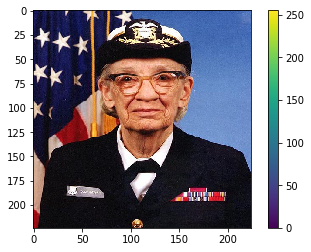

In [3]:
# Predict an image from the ImageNet.
grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))

# Display the image.
plt.figure()
plt.imshow(grace_hopper)
plt.colorbar()
plt.show()

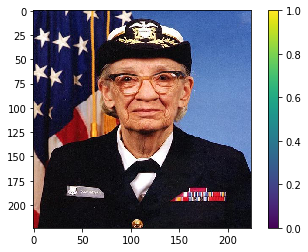

In [4]:
# Normalize the image values.
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

# Display the image.
plt.figure()
plt.imshow(grace_hopper)
plt.colorbar()
plt.show()

In [5]:
# Predict the image.
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [6]:
# Get class ID.
predict_id = np.argmax(result[0], axis=-1)
print('Predict Class ID:', predict_id)

Predict Class ID: 653


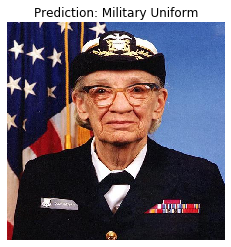

In [11]:
# Get labels.
path_labels = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels      = np.array(open(path_labels).read().splitlines())
label       = labels[predict_id]

plt.imshow(grace_hopper)
plt.axis('off')
plt.title('Prediction: ' + label.title())
plt.show()

In [0]:
# Using pretrain model for Cats vs Dogs.
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)
(train_data, validate_data) = splits

num_samples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

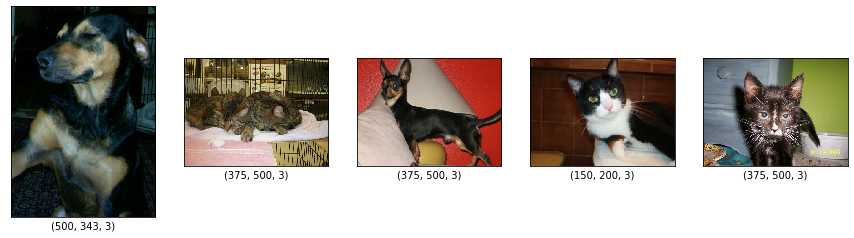

In [20]:
# Display some of the samples.
samples = train_data.take(5)
plt.figure(figsize=(15, 15))
for i, img in enumerate(samples):
  plt.subplot(1, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[0])
  plt.xlabel(img[0].shape)
plt.show()

In [0]:
# Resize the images.
def formatImage(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
  return image, label

BATCH_SIZE = 32
train_batches     = train_data.shuffle(num_samples//4).map(formatImage).batch(BATCH_SIZE).prefetch(1)
validate_batches  = validate_data.map(formatImage).batch(BATCH_SIZE).prefetch(1) 

In [30]:
# Predict an image batch.
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch        = model.predict(image_batch)
predict_class_ids   = np.argmax(result_batch, axis=-1)
predict_class_names = labels[predict_class_ids]
print('Class IDs:  ', predict_class_ids)
print('Class Names:', predict_class_names)

Class IDs:   [589 171 206 208 209 282 238 167 490 284 282 209 286 163 190 264 285 286
 282 167 225 286 282 286 228 284 282 203 167 288 228 210]
Class Names: ['hamper' 'Irish wolfhound' 'flat-coated retriever' 'golden retriever'
 'Labrador retriever' 'tabby' 'miniature pinscher' 'Walker hound'
 'chainlink fence' 'Persian cat' 'tabby' 'Labrador retriever'
 'Egyptian cat' 'beagle' 'Lakeland terrier' 'Pembroke' 'Siamese cat'
 'Egyptian cat' 'tabby' 'Walker hound' 'groenendael' 'Egyptian cat'
 'tabby' 'Egyptian cat' 'kelpie' 'Persian cat' 'tabby'
 'soft-coated wheaten terrier' 'Walker hound' 'lynx' 'kelpie'
 'Chesapeake Bay retriever']


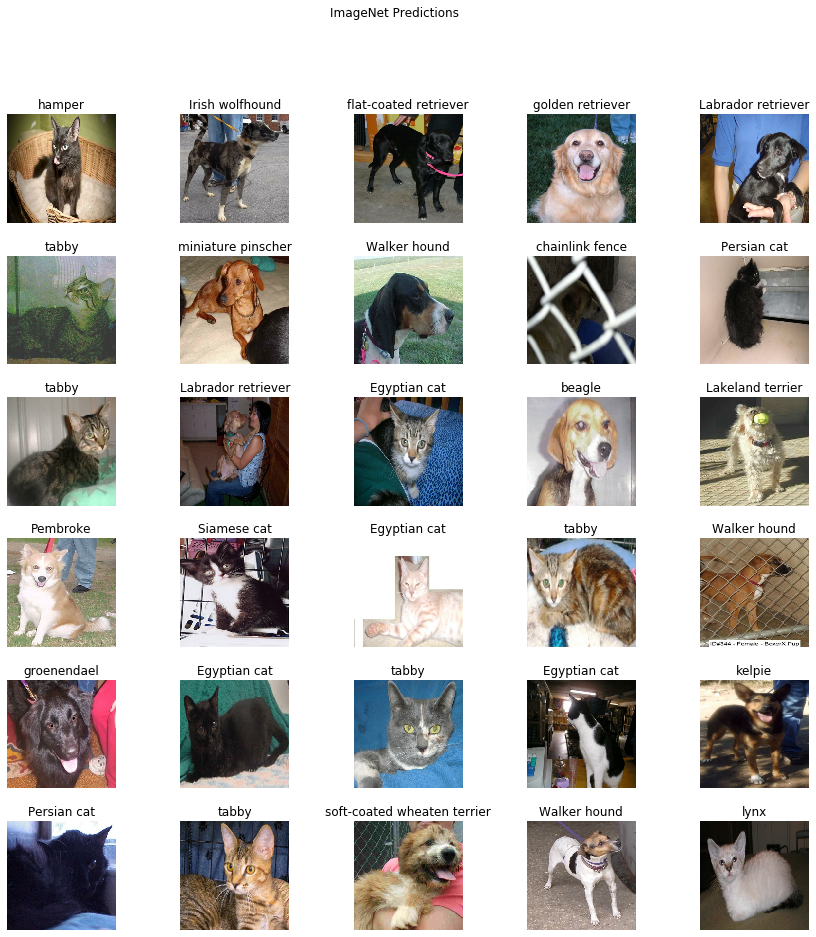

In [32]:
# Display the result.
plt.figure(figsize=(15, 15))
for i in range(30):
  plt.subplot(6, 5, i + 1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[i])
  plt.title(predict_class_names[i])
  plt.axis('off')
_ = plt.suptitle('ImageNet Predictions')

In [33]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_batch     = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
# Freeze the model.
feature_extractor.trainable = False

In [37]:
# Build our model.
model = tf.keras.Sequential()
model.add(feature_extractor)
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [40]:
# Train the model.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
EPOCHS = 6
history = model.fit(train_batches, epochs=EPOCHS, validation_data = validate_batches)

Epoch 1/6
582/582 [==============================] - 68s 116ms/step - loss: 0.0213 - accuracy: 0.9928 - val_loss: 0.0328 - val_accuracy: 0.9873
Epoch 2/6
582/582 [==============================] - 64s 111ms/step - loss: 0.0188 - accuracy: 0.9937 - val_loss: 0.0332 - val_accuracy: 0.9881
Epoch 3/6
582/582 [==============================] - 64s 110ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.0333 - val_accuracy: 0.9884
Epoch 4/6
582/582 [==============================] - 66s 114ms/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0332 - val_accuracy: 0.9890
Epoch 5/6
582/582 [==============================] - 64s 110ms/step - loss: 0.0134 - accuracy: 0.9959 - val_loss: 0.0362 - val_accuracy: 0.9881
Epoch 6/6
582/582 [==============================] - 64s 111ms/step - loss: 0.0117 - accuracy: 0.9960 - val_loss: 0.0374 - val_accuracy: 0.9877


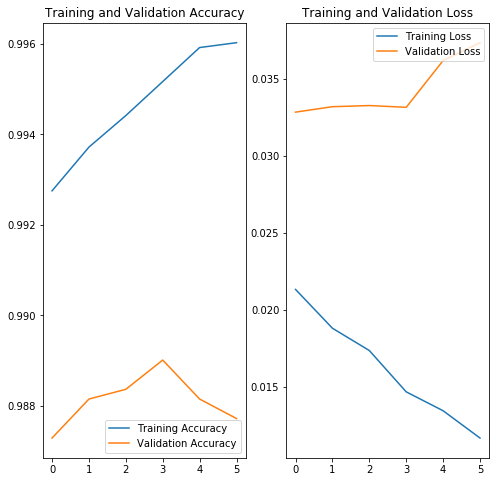

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
class_names = np.array(info.features['label'].names)
print('Class Names:', class_names)

Class Names: ['cat' 'dog']


In [44]:
# Predict with the new model.
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids   = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print('Predicted IDs:    ', predicted_ids)
print('Predicted Classes:', predicted_class_names)

Predicted IDs:     [0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0]
Predicted Classes: ['cat' 'dog' 'dog' 'dog' 'dog' 'cat' 'dog' 'dog' 'dog' 'cat' 'cat' 'dog'
 'cat' 'dog' 'dog' 'dog' 'cat' 'cat' 'cat' 'dog' 'dog' 'cat' 'cat' 'cat'
 'dog' 'cat' 'cat' 'dog' 'dog' 'cat' 'dog' 'cat']


In [45]:
print('Labels:          ', label_batch)
print('Predicted Labels:', predicted_ids)

Labels:           [0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 1]
Predicted Labels: [0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0]


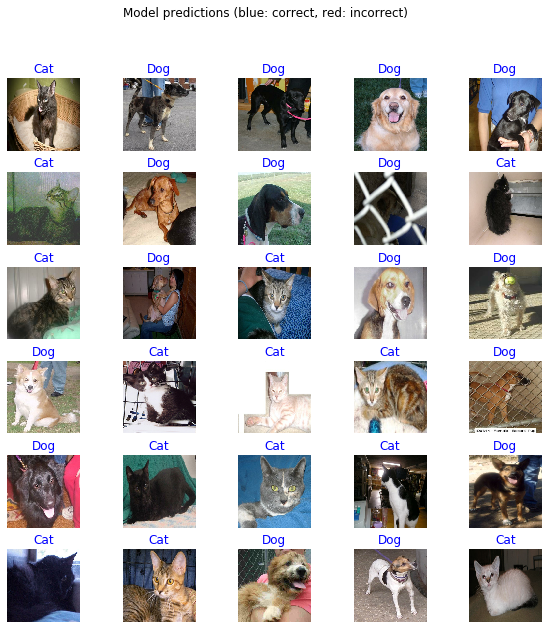

In [48]:
plt.figure(figsize=(10, 10))
for i in range(30):
  plt.subplot(6, 5, i + 1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[i])
  color = "blue" if predicted_ids[i] == label_batch[i] else "red"
  plt.title(predicted_class_names[i].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")